In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import cmapy

[[ 1.          0.        ]
 [ 0.6234898   0.78183148]
 [-0.22252093  0.97492791]
 [-0.90096887  0.43388374]
 [-0.90096887 -0.43388374]
 [-0.22252093 -0.97492791]
 [ 0.6234898  -0.78183148]]


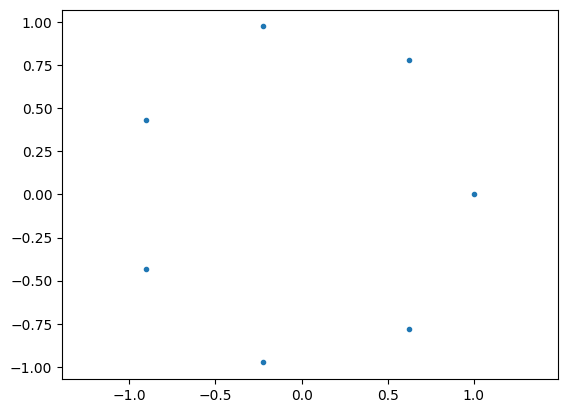

In [11]:
N=7
pts=np.exp(1j*2*np.pi*np.arange(N)/N)
pt=np.array([pts.real,pts.imag]).T
print(pt)
plt.plot(pt[:,0],pt[:,1],".")
plt.axis("equal")
plt.show()

In [121]:

def force_magnet(pos,axis=0):
    q=np.ones(N)
    F=np.zeros(2)
    for i in range(N):
        r=pos-pt[i]
        dist=np.linalg.norm(r,axis=axis)
        #if dist>1e-6:F+=q[i]*r/dist**3
        F+=q[i]*r/dist**3
    return F

def force_spring(pos,axis=0):
    k=np.ones(N)
    F=np.zeros(2)
    for i in range(N):
        r=pos-pt[i]
        dist=np.linalg.norm(r,axis=axis)
        #if dist>1e-6:F+=-k[i]*r
        F+=-k[i]*r
    return F

def evolve(pos,vel,axis=0):
    del_t=3e-2
    k_f=-0.0
    vel+=(force_magnet(pos,axis)+force_spring(pos,axis)+k_f*vel)*del_t
    pos+=vel*del_t
    return pos,vel

def check(pos):
    dist=[]
    for i in range(N):
        dist.append(np.linalg.norm(pos-pt[i]))
    dist.append(np.linalg.norm(pos))
    index_min = np.argmin(dist)
    return index_min



In [103]:
n_iter=1000
pos=np.zeros((2,n_iter))
pos[:,0]=np.random.randn(2)
vel=np.zeros((2,n_iter))
vel[:,0]=np.zeros(2)
col=np.zeros((1,n_iter))
col[:,0]=check(pos[:,0])

for i in range(1,n_iter):
    pos[:,i],vel[:,i]=evolve(pos[:,i-1],vel[:,i-1]) 
    col[:,i]=check(pos[:,i])

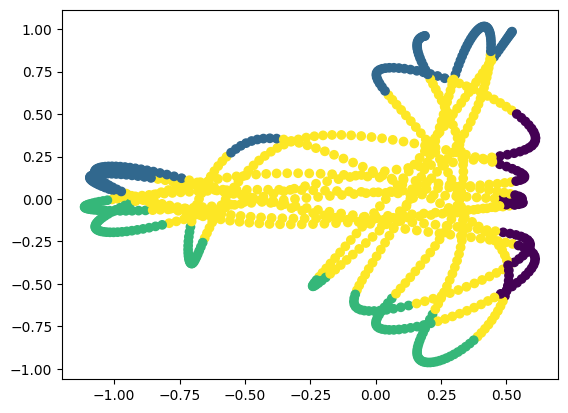

In [102]:
plt.scatter(pos[0,:],pos[1,:],c=col[0,:])
plt.show()

In [139]:
N_grid=101
xv, yv = np.meshgrid(np.linspace(-1, 1, N_grid), np.linspace(-1, 1, N_grid))
pos=np.stack((xv,yv),axis=2)
vel=np.zeros((N_grid,N_grid,2))

In [165]:
n_iter=1000
M=10
col=np.zeros((n_iter,N_grid,N_grid))
col[0,:,:]=check_2d(pos)
for i in range(1,n_iter):
    pos,vel=evolve_2d(pos,vel,k_f=-0.2) 
    col[i,:,:]=check_2d(pos)

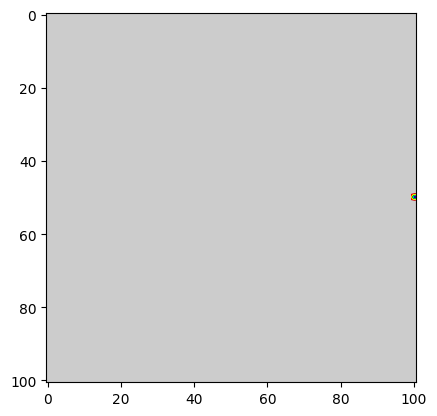

In [166]:
plt.imshow(col[-1,:,:],interpolation='Bilinear',cmap='nipy_spectral')
plt.show()

In [4]:
def check_2d(pos):
    dist=[]
    for i in range(N):
        dist.append(np.linalg.norm(pos-pt[i],axis=2))
    #dist.append(np.linalg.norm(pos,axis=2))
    dist=np.array(dist)
    index_min = np.argmin(dist,axis=0)/(N)
    return index_min

def force_magnet_2d(pos):
    q=q_0*np.ones(N)
    F=np.zeros(np.shape(pos))
    for i in range(N):
        r=pos-pt[i]
        dist=(np.linalg.norm(r,axis=2).reshape(N_grid,N_grid,1)**2+h**2)**0.5+1e-10
        F+=q[i]*r/dist**3
    return F

def evolve_2d(pos,vel):
    del_v=(force_magnet_2d(pos)-k_0*pos-k_f*vel)*del_t
    del_x=vel*del_t
    pos+=del_x
    vel+=del_v
    return pos,vel

In [12]:
k_f=0.15
k_0=0.04
h=0.2
q_0=1
del_t=4e-2
v_0=1e0
res_x,res_y=1200,1200
n_iter=1000
N_grid=800
k_size=10

folder="E:/renders/Magnetic_pendullum"
file='/Mag_vel__k_f={0}_k_0={1}_q_0={2}_del_t={3}.avi'.format(k_f,k_0,q_0,del_t)
out = cv2.VideoWriter(folder+file,cv2.VideoWriter_fourcc(*'DIVX'), 30, (res_x,res_y))

xv, yv = np.meshgrid(np.linspace(-1, 1, N_grid), np.linspace(-1, 1, N_grid))
pos=np.stack((xv,yv),axis=2)
norm=(xv**2+yv**2)**0.5
#vel=np.zeros((N_grid,N_grid,2))
vel=v_0*np.stack((-yv/norm**1,xv/norm**1),axis=2)
kernel = np.ones((k_size,k_size),np.float32)/k_size**2

for i in range(1,n_iter):
    pos,vel=evolve_2d(pos,vel) 
    img = (check_2d(pos)*255).astype(np.uint8)
    
    img = cv2.resize(img, (res_x,res_y),interpolation=cv2.INTER_LANCZOS4)
    img = cv2.filter2D(img,-1,kernel)
    #img = cv2.GaussianBlur(img,(5,5),0)
    imS = cv2.applyColorMap(img, cmapy.cmap('magma'))
    out.write(imS)
out.release()

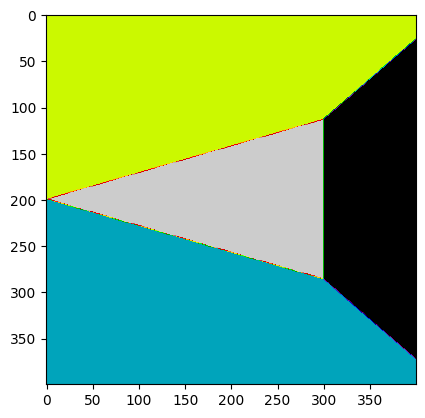

In [25]:
plt.imshow(col[0,:,:],interpolation='Bilinear',cmap='nipy_spectral')
plt.show()

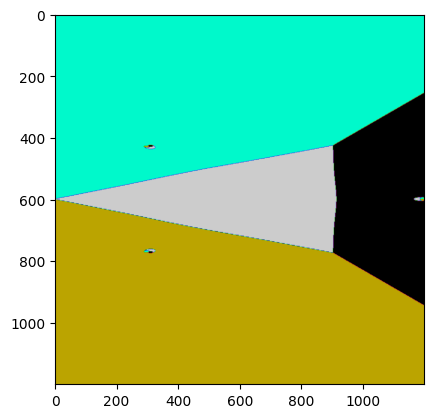

In [31]:
k_f=0.6
del_t=1e-2
res_x,res_y=1200,1200
n_iter=10
N_grid=800

xv, yv = np.meshgrid(np.linspace(-1, 1, N_grid), np.linspace(-3, 3, N_grid))
pos=np.stack((xv,yv),axis=2)
vel=np.zeros((N_grid,N_grid,2))

for i in range(1,n_iter):
    pos,vel=evolve_2d(pos,vel,-k_f,del_t) 
    img = (check_2d(pos)*255/3).astype(np.uint8)
    img = cv2.resize(img, (res_x,res_y))
    imS = cv2.applyColorMap(img, cmapy.cmap('nipy_spectral'))
plt.imshow(imS)
plt.show()